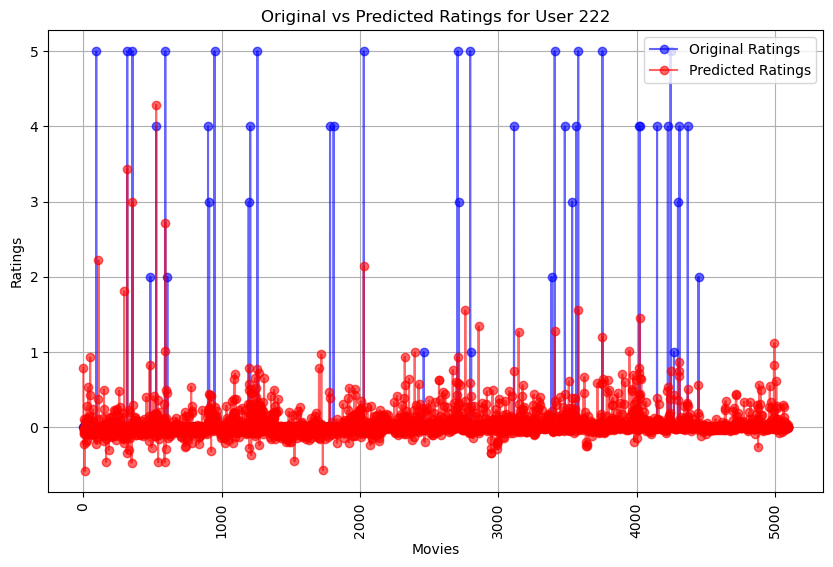

U Matrix Shape: (7119, 40)
Sigma Matrix Shape: (40, 40)
Vt Matrix Shape: (40, 4837)


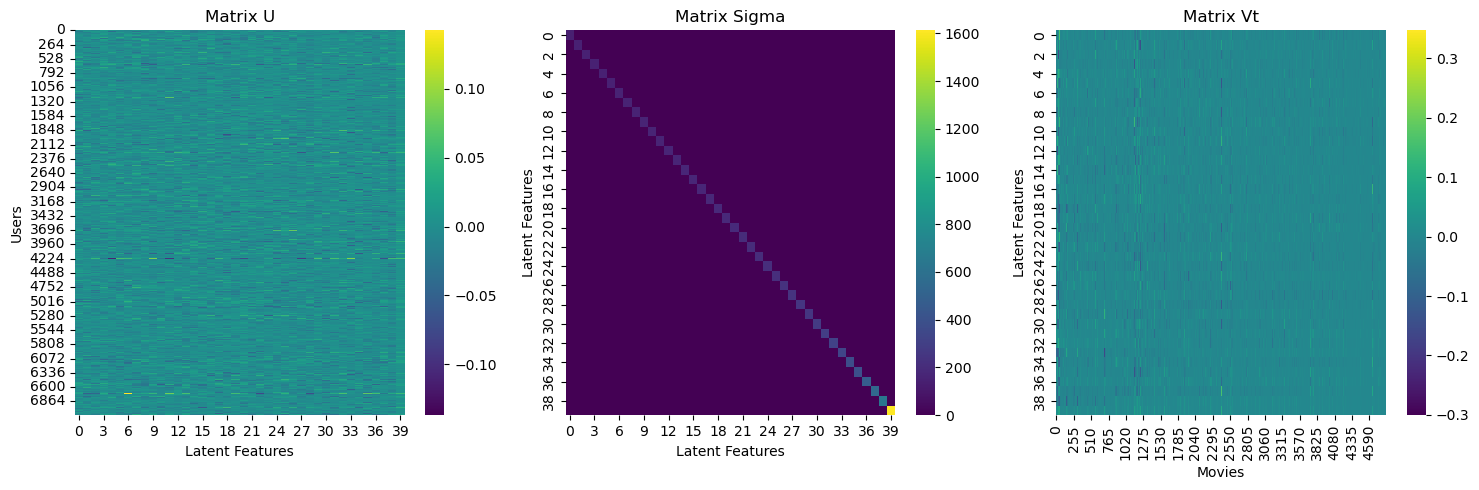

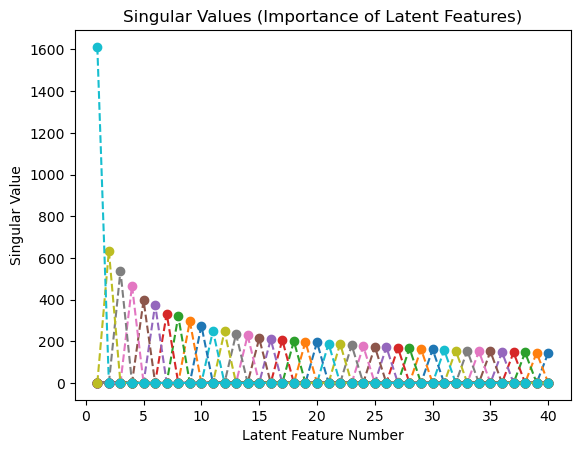


Top 10 Recommended Movies for User 222 (based on past and predicted ratings):
Beautiful Girls (1996): ★★★★★ (Rating: 5.0)
Dances with Wolves (1990): ★★★★★ (Rating: 5.0)
Braveheart (1995): ★★★★★ (Rating: 5.0)
East of Eden (1955): ★★★★★ (Rating: 5.0)
Some Like It Hot (1959): ★★★★★ (Rating: 5.0)
Breakfast at Tiffany's (1961): ★★★★★ (Rating: 5.0)
Silence of the Lambs, The (1991): ★★★★★ (Rating: 5.0)
Fargo (1996): ★★★★★ (Rating: 5.0)
Schindler's List (1993): ★★★★★ (Rating: 5.0)
Last Action Hero (1993): ★★★★★ (Rating: 5.0)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
import random

# Load datasets
movies = pd.read_csv('C:\\Users\\Bhoomika Swamy\\Downloads\\Movie_Data.csv', encoding='ISO-8859-1')
ratings = pd.read_csv('C:\\Users\\Bhoomika Swamy\\Downloads\\Ratings_Data.csv', encoding='ISO-8859-1')
tags = pd.read_csv('C:\\Users\\Bhoomika Swamy\\Downloads\\Tags_Data.csv', encoding='ISO-8859-1')

# Prepare the user-movie ratings matrix
user_movie_ratings = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Convert the user_movie_ratings DataFrame into a sparse matrix
user_movie_ratings_sparse = csr_matrix(user_movie_ratings.values)

# Choose an appropriate k value for the data
k_value = 40  # You can adjust this value based on your analysis

# Apply SVD to the User-Movie ratings matrix
U, sigma, Vt = svds(user_movie_ratings_sparse, k=k_value)  # We choose k latent factors
sigma = np.diag(sigma)  # Convert sigma into a diagonal matrix

# Reconstruct the matrix for predictions
reconstructed_ratings = np.dot(np.dot(U, sigma), Vt)

# Convert the matrix back to DataFrame for easy interpretation
predicted_ratings_df = pd.DataFrame(reconstructed_ratings, columns=user_movie_ratings.columns)

# Define a function to recommend movies based on both past ratings and predicted ratings
def recommend_movies_with_history(user_id, num_recommendations=10):
    # Get the user's original ratings (actual ratings given by the user)
    original_ratings = user_movie_ratings.loc[user_id]
    
    # Predicted ratings from SVD
    predicted_ratings = pd.Series(reconstructed_ratings[user_id - 1], index=user_movie_ratings.columns)

    # Separate rated and unrated movies
    rated_movies = original_ratings[original_ratings > 0].index
    unrated_movies = original_ratings[original_ratings == 0].index
    
    # Sort rated movies by the user's rating, to recommend their favorites
    top_rated_movies = original_ratings[rated_movies].sort_values(ascending=False)
    
    # Recommend unrated movies based on predicted ratings
    top_predicted_movies = predicted_ratings[unrated_movies].sort_values(ascending=False)[:num_recommendations]
    
    # Combine both rated and predicted into a single DataFrame
    # We give preference to past rated movies, followed by predicted ratings
    recommended_movies = pd.concat([top_rated_movies, top_predicted_movies])
    
    # Get movie titles from the movies DataFrame and add the corresponding predicted rating
    recommended_movies_df = movies[movies['movieId'].isin(recommended_movies.index)].copy()
    recommended_movies_df['rating'] = recommended_movies.values

    return recommended_movies_df[['title', 'rating']].sort_values(by='rating', ascending=False)

# Randomly select a user ID from the dataset
user_id = random.choice(user_movie_ratings.index)

# Test the function with the randomly selected user
recommended_movies = recommend_movies_with_history(user_id, num_recommendations=10)

# Visualize the original vs predicted ratings for the selected user
def plot_user_ratings(user_id):
    original_ratings = user_movie_ratings.loc[user_id]
    predicted_ratings = pd.Series(reconstructed_ratings[user_id - 1], index=user_movie_ratings.columns)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(original_ratings.index, original_ratings, label='Original Ratings', marker='o', color='blue', alpha=0.6)
    plt.plot(predicted_ratings.index, predicted_ratings, label='Predicted Ratings', marker='o', color='red', alpha=0.6)
    
    plt.xlabel('Movies')
    plt.ylabel('Ratings')
    plt.title(f'Original vs Predicted Ratings for User {user_id}')
    plt.xticks(rotation=90)  # Rotate movie titles for better readability
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot user rating comparison for the randomly selected user
plot_user_ratings(user_id)

# Print the SVD matrices
print("U Matrix Shape:", U.shape)
print("Sigma Matrix Shape:", sigma.shape)
print("Vt Matrix Shape:", Vt.shape)

# Function to plot SVD matrices
def plot_svd_matrices(U, sigma, Vt):
    # Plot U matrix
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.heatmap(U, cmap='viridis', cbar=True)
    plt.title('Matrix U')
    plt.xlabel('Latent Features')
    plt.ylabel('Users')

    # Plot Sigma matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(sigma, cmap='viridis', cbar=True)
    plt.title('Matrix Sigma')
    plt.xlabel('Latent Features')
    plt.ylabel('Latent Features')

    # Plot Vt matrix
    plt.subplot(1, 3, 3)
    sns.heatmap(Vt, cmap='viridis', cbar=True)
    plt.title('Matrix Vt')
    plt.xlabel('Movies')
    plt.ylabel('Latent Features')

    plt.tight_layout()
    plt.show()

plot_svd_matrices(U, sigma, Vt)

# Plot the singular values (sigma) to observe the importance of latent features
plt.plot(np.arange(1, len(sigma) + 1), sigma[::-1], marker='o', linestyle='--')
plt.title('Singular Values (Importance of Latent Features)')
plt.xlabel('Latent Feature Number')
plt.ylabel('Singular Value')
plt.show()

# Display recommended movies with star ratings
def colored_stars(rating):
    stars = '★' * int(np.round(rating)) + '☆' * (5 - int(np.round(rating)))  # Create star representation
    return f"\033[91m{stars}\033[0m"  # ANSI escape code for red
def bold_text(text):
    return f"\033[1m{text}\033[0m"  # ANSI escape code for bold
    
# Display recommended movie titles
# Display top 10 recommended movie titles
print("\nTop 10 Recommended Movies for User", user_id, "(based on past and predicted ratings):")
for _, row in recommended_movies.head(10).iterrows():  # Get top 10
    title = row['title']
    rating = row['rating']
    stars = colored_stars(rating)  # Get colored stars
    bold_title = bold_text(title)  # Get bold title
    print(f"{bold_title}: {stars} (Rating: {rating:.1f})")
